In [ ]:
import pandas as pd
import numpy as np
import torch

use_cols = ['user_id', 'item_id', 'timestamp', 'click', 'like', 'follow', 'search']
df = pd.read_csv('../data/KuaiSAR_final/rec_inter.csv', usecols=use_cols)

# Setup Device (GPU/CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CUDA GPU


## data cleaning & preprocessing

In [3]:
# data cleaning & preprocessing

for c in ["click","like","follow","search"]:
    df[c] = df[c].fillna(0).astype(np.int8)

# only keep recommendation interaction(none search)
df = df[df['search'] == 0]

df['pos'] = ((df['click'] + df['like'] + df['follow']) > 0).astype(np.int8)

# timestamp
ts = pd.to_numeric(df['timestamp'], errors='coerce')
df = df[ts.notna()].copy()
df['ts'] = ts.astype('int64')

### EDA

In [2]:
# Core user & item statistics

num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()
num_interactions = len(df)

# sequence length = number of interactions per user
user_seq_len = df.groupby('user_id').size()
avg_seq_len = user_seq_len.mean()

print(f"Number of users: {num_users:,}")
print(f"Number of items: {num_items:,}")
print(f"Total interactions: {num_interactions:,}")
print(f"Average sequence length per user: {avg_seq_len:.2f}")

Number of users: 25,877
Number of items: 2,281,034
Total interactions: 7,493,101
Average sequence length per user: 289.57


### Distribution of User Sequence Lengths

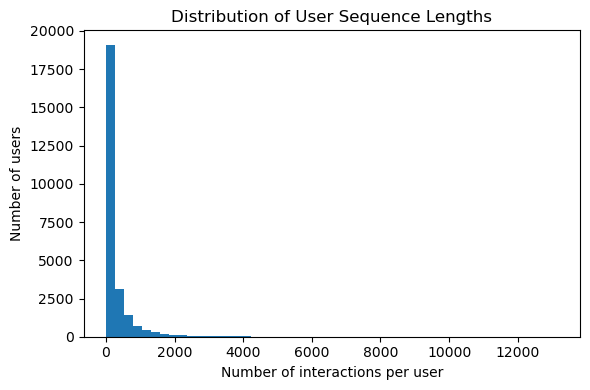

In [3]:
import matplotlib.pyplot as plt

# Histogram of user sequence lengths (number of interactions per user)
plt.figure(figsize=(6, 4))
plt.hist(user_seq_len, bins=50)
plt.xlabel("Number of interactions per user")
plt.ylabel("Number of users")
plt.title("Distribution of User Sequence Lengths")
plt.tight_layout()
plt.show()

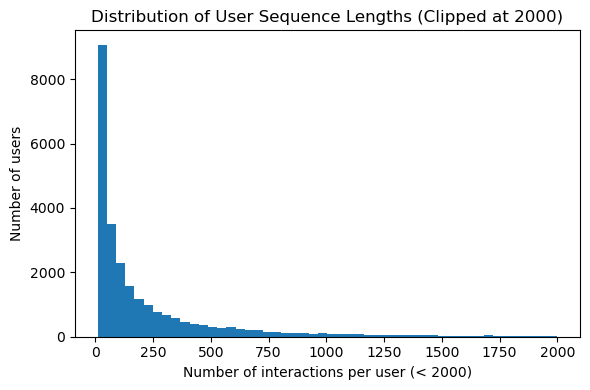

In [4]:
import matplotlib.pyplot as plt

# Filter users with fewer than 2000 interactions
filtered_seq = user_seq_len[user_seq_len < 2000]

plt.figure(figsize=(6, 4))
plt.hist(filtered_seq, bins=50)
plt.xlabel("Number of interactions per user (< 2000)")
plt.ylabel("Number of users")
plt.title("Distribution of User Sequence Lengths (Clipped at 2000)")
plt.tight_layout()
plt.show()

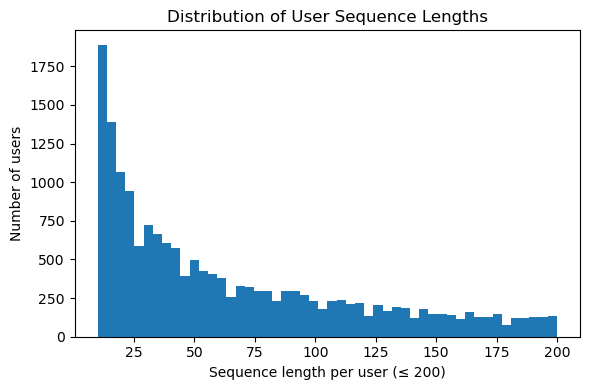

In [5]:
user_seq_len = df.groupby("user_id").size()

user_seq_len.head()

max_len = 200  
filtered = user_seq_len[user_seq_len <= max_len]

plt.figure(figsize=(6, 4))
plt.hist(filtered, bins=50)
plt.xlabel(f"Sequence length per user (≤ {max_len})")
plt.ylabel("Number of users")
plt.title("Distribution of User Sequence Lengths")
plt.tight_layout()
plt.show()

In [4]:
# ==========================================
# 1. Iterative Filtering (Core Stability)
# ==========================================
# Keep top K items to avoid OOM and reduce noise
target_item_count = 50000
min_user_inter = 5

print(f"Original: {len(df)} interactions")

# Filter Items first (Keep Top 50k)
item_counts = df['item_id'].value_counts()
if len(item_counts) > target_item_count:
    top_items = item_counts.head(target_item_count).index
    df_filtered = df[df['item_id'].isin(top_items)].copy()
else:
    df_filtered = df.copy()

# Filter Users (Keep >= 5 interactions)
# We might need a loop because removing users might reduce item counts, and vice versa
# But for simplicity, one pass usually works well enough for coursework
user_counts = df_filtered['user_id'].value_counts()
valid_users = user_counts[user_counts >= min_user_inter].index
df_filtered = df_filtered[df_filtered['user_id'].isin(valid_users)].copy()

print(f"Filtered: {len(df_filtered)} interactions")
print(f"Users: {df_filtered['user_id'].nunique()}, Items: {df_filtered['item_id'].nunique()}")

# ==========================================
# 2. ID Remapping
# ==========================================
unique_users = df_filtered['user_id'].unique()
unique_items = df_filtered['item_id'].unique()

user2idx = {uid: i for i, uid in enumerate(unique_users)}
item2idx = {iid: i for i, iid in enumerate(unique_items)}

df_filtered['user_idx'] = df_filtered['user_id'].map(user2idx)
df_filtered['item_idx'] = df_filtered['item_id'].map(item2idx)

num_users = len(unique_users)
num_items = len(unique_items)

# ==========================================
# 3. Train/Test Split
# ==========================================
df_filtered = df_filtered.sort_values(['user_idx', 'ts'])
grouped = df_filtered.groupby('user_idx')
test = df_filtered.loc[grouped.tail(1).index]
train = df_filtered.drop(test.index)

print(f"Train: {len(train)}, Test: {len(test)}")
user_histories = train.groupby('user_idx')['item_idx'].apply(set).to_dict()


Original: 7461153 interactions
Filtered: 2621974 interactions
Users: 23936, Items: 50000
Train: 2598038, Test: 23936


## Most Popular Baseline

In [5]:
# ==========================================
# 1. Define Reusable Evaluation Function
# ==========================================
def evaluate_model(model_name, test_df, topk_preds, K=50):
    """
    test_df: DataFrame with 'user_idx' and 'item_idx' (ground truth)
    topk_preds: dict or Series, user_idx -> list of top K item_indices
    """
    hits = []
    ndcgs = []

    # Convert predictions to a dict for fast lookup if it isn't already
    if not isinstance(topk_preds, dict):
        pred_dict = topk_preds.to_dict()
    else:
        pred_dict = topk_preds

    for _, row in test_df.iterrows():
        u = row['user_idx']
        gt = row['item_idx']

        # Get recommendations for this user, default to empty if missing
        recs = pred_dict.get(u, [])

        # HR@K
        if gt in recs:
            hits.append(1)
            # NDCG@K
            rank = recs.index(gt)
            ndcgs.append(1.0 / np.log2(rank + 2))
        else:
            hits.append(0)
            ndcgs.append(0.0)

    hr = np.mean(hits)
    ndcg = np.mean(ndcgs)
    print(f"[{model_name}] HR@{K}: {hr:.4f}  NDCG@{K}: {ndcg:.4f}")
    return hr, ndcg

# ==========================================
# 2. Run Most Popular Baseline
# ==========================================
# Calculate popularity on TRAIN set only (avoid data leakage)
# Using weighted popularity as you did before
train['w'] = (1*train['click'] + 2*train['like'] + 3*train['follow']).astype(np.int16)
pop_scores = train.groupby('item_idx')['w'].sum().sort_values(ascending=False)

# Get global Top-K list
K = 50
global_topk = pop_scores.index[:K].tolist()

# Assign user-specific topk excluding seen items
all_ranked_items = pop_scores.index.tolist()
most_pop_preds = {}
for u in test['user_idx'].unique():
    seen = user_histories.get(u, set())
    recs = []
    for iid in all_ranked_items:
        if iid in seen:
            continue
        recs.append(iid)
        if len(recs) >= K:
            break
    most_pop_preds[u] = recs

# Evaluate
hr_MP, ndcg_MP = evaluate_model("MostPopular", test, most_pop_preds, K=50)


[MostPopular] HR@50: 0.0316  NDCG@50: 0.0094


## Item CF

In [ ]:
import torch
from sklearn.preprocessing import normalize

# Prepare Indices and Values from Train Data
indices = torch.tensor([train['user_idx'].values, train['item_idx'].values], dtype=torch.long)
values = torch.tensor(train['w'].values, dtype=torch.float32)
shape = torch.Size((num_users, num_items))


# Construct User-Item Sparse Matrix
# user_item_mat: (Users x Items)
user_item_mat = torch.sparse_coo_tensor(indices, values, shape, device=device)
print(f"Sparse User-Item Matrix Shape: {user_item_mat.shape}")

Using CUDA GPU
Sparse User-Item Matrix Shape: torch.Size([23926, 50000])


/tmp/ipython-input-1095330765.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  indices = torch.tensor([train['user_idx'].values, train['item_idx'].values], dtype=torch.long)


In [ ]:
# Calculate Item-Item Similarity (Cosine)

# Transpose to (Items x Users)
item_user_mat = user_item_mat.t()

item_user_dense = item_user_mat.to_dense()
item_norms = torch.norm(item_user_dense, p=2, dim=1, keepdim=True)
item_norms[item_norms == 0] = 1e-9
item_user_norm = item_user_dense / item_norms
sim_matrix = torch.mm(item_user_norm, item_user_norm.t()) # (Items x Items)

sim_matrix.fill_diagonal_(0)


tensor([[0.0000, 0.0418, 0.0415,  ..., 0.0000, 0.0000, 0.0000],
        [0.0418, 0.0000, 0.0805,  ..., 0.0000, 0.0000, 0.0000],
        [0.0415, 0.0805, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [ ]:
# Generate Recommendations
from tqdm import tqdm


# 5. Generate Recommendations
item_cf_preds = {}
K = 50
test_users_arr = test['user_idx'].unique()
batch_size = 200 # Adjust based on memory

for i in tqdm(range(0, len(test_users_arr), batch_size), desc="Predicting"):
    batch_uids = test_users_arr[i : i + batch_size]
    batch_uids_tensor = torch.tensor(batch_uids, device=device)

    # Get History: (Batch x Items)
    # index_select works on dense or sparse (if supported)
    # converting batch history to dense for calculation
    batch_hist = user_item_mat.index_select(0, batch_uids_tensor).to_dense()

    # Score: (Batch x Items) * (Items x Items) -> (Batch x Items)
    scores = torch.mm(batch_hist, sim_matrix)

    # Mask seen items
    scores = scores - 9999.0 * batch_hist

    # Top-K
    _, topk_indices = torch.topk(scores, k=K, dim=1)

    # Store
    topk_cpu = topk_indices.cpu().numpy()
    for idx, u in enumerate(batch_uids):
        item_cf_preds[u] = topk_cpu[idx].tolist()

# 6. Evaluate
hr_IC, ndcg_IC = evaluate_model("ItemCF", test, item_cf_preds, K=50)

Predicting: 100%|██████████| 120/120 [00:07<00:00, 15.47it/s]


[ItemCF] HR@50: 0.0548  NDCG@50: 0.0160


## NeuMF (NeuCF)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

# ==========================================
# 1. NeuMF Dataset with Negative Sampling
# ==========================================
class NeuMFDataset(Dataset):
    def __init__(self, train_df, num_items, num_neg=4):
        self.users = torch.tensor(train_df['user_idx'].values, dtype=torch.long)
        self.items = torch.tensor(train_df['item_idx'].values, dtype=torch.long)
        self.num_items = num_items
        self.num_neg = num_neg

        # Pre-compute a set of interacted items for each user for fast negative sampling
        # set lookup is O(1)
        self.user_item_set = train_df.groupby('user_idx')['item_idx'].apply(set).to_dict()

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        # Positive sample
        u = self.users[idx]
        i = self.items[idx]

        # Negative sampling
        # We need to find an item 'j' that user 'u' has NOT seen
        item_indices = []
        labels = []

        # Add Positive
        item_indices.append(i)
        labels.append(1.0)

        # Add Negatives
        interacted_items = self.user_item_set.get(u.item(), set())

        for _ in range(self.num_neg):
            j = random.randint(0, self.num_items - 1)
            # Simple rejection sampling
            while j in interacted_items:
                j = random.randint(0, self.num_items - 1)

            item_indices.append(torch.tensor(j, dtype=torch.long))
            labels.append(0.0)

        return u, torch.stack(item_indices), torch.tensor(labels, dtype=torch.float32)

# Create Dataset and DataLoader
# num_neg=4 is standard for NCF/NeuMF
train_dataset = NeuMFDataset(train, num_items=num_items, num_neg=4)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

print("NeuMF Dataset Ready.")

NeuMF Dataset Ready.


In [9]:
# ==========================================
# 2. NeuMF Model Architecture
# ==========================================
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super(NeuMF, self).__init__()

        # --- GMF Part ---
        self.gmf_user_embed = nn.Embedding(num_users, embedding_dim)
        self.gmf_item_embed = nn.Embedding(num_items, embedding_dim)

        # --- MLP Part ---
        self.mlp_user_embed = nn.Embedding(num_users, embedding_dim)
        self.mlp_item_embed = nn.Embedding(num_items, embedding_dim)

        # MLP Layers: Input(2*dim) -> dim -> dim/2 -> 1
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, embedding_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # --- Prediction Layer ---
        # Concatenate GMF output (dim) and MLP output (dim/2)
        self.output = nn.Linear(embedding_dim + embedding_dim // 2, 1)

        # Init weights (Optional but recommended)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, std=0.01)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, user, item):
        # GMF
        gmf_u = self.gmf_user_embed(user)
        gmf_i = self.gmf_item_embed(item)
        gmf_vector = gmf_u * gmf_i # Element-wise product

        # MLP
        mlp_u = self.mlp_user_embed(user)
        mlp_i = self.mlp_item_embed(item)
        mlp_input = torch.cat([mlp_u, mlp_i], dim=-1)
        mlp_vector = self.mlp(mlp_input)

        # Concat & Predict
        combined = torch.cat([gmf_vector, mlp_vector], dim=-1)
        prediction = self.output(combined)

        # Note: We don't use Sigmoid here because we use BCEWithLogitsLoss later
        return prediction.squeeze()

# Instantiate Model
model = NeuMF(num_users, num_items, embedding_dim=64).to(device)
print(model)

NeuMF(
  (gmf_user_embed): Embedding(23936, 64)
  (gmf_item_embed): Embedding(50000, 64)
  (mlp_user_embed): Embedding(23936, 64)
  (mlp_item_embed): Embedding(50000, 64)
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (output): Linear(in_features=96, out_features=1, bias=True)
)


Epoch 20/20: 100%|██████████| 2538/2538 [01:15<00:00, 33.44it/s, loss=0.097] 


Training Finished.


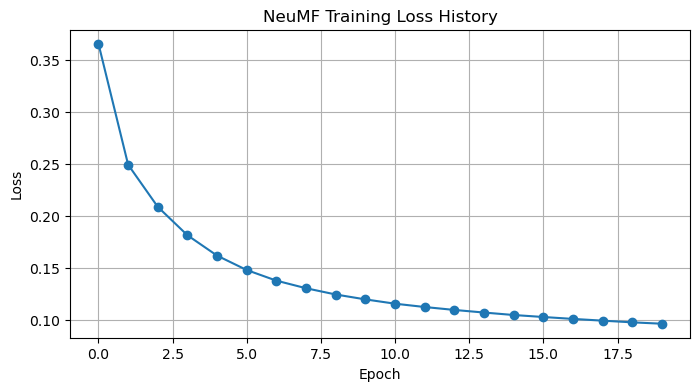

NeuMF Prediction: 100%|██████████| 23936/23936 [03:33<00:00, 111.86it/s]


[NeuMF] HR@50: 0.0752  NDCG@50: 0.0213


(0.07515875668449198, 0.021265630738060672)

In [11]:
# ==========================================
# 3. Training Loop
# ==========================================
from tqdm import tqdm
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20 
model.train()
loss_history = []

for epoch in range(epochs):
    total_loss = 0

    # Progress bar for each epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for u, items, labels in pbar:
        u, items, labels = u.to(device), items.to(device), labels.to(device)

        # Flatten input for batch processing
        # items shape: (batch, 1+num_neg) -> (batch * (1+num_neg))
        # We repeat user '1+num_neg' times to match items
        batch_size_curr = u.shape[0]
        num_samples = items.shape[1]

        u_flat = u.repeat_interleave(num_samples)
        items_flat = items.view(-1)
        labels_flat = labels.view(-1)

        optimizer.zero_grad()
        preds = model(u_flat, items_flat)
        loss = criterion(preds, labels_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
print("Training Finished.")

neumf_loss_history = loss_history
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(neumf_loss_history, marker='o')
plt.title("NeuMF Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
# ==========================================
# 4. Generate Recommendations (Inference)
# ==========================================
model.eval()
neumf_preds = {}
test_users = test['user_idx'].unique()
K = 50

# For NeuMF, scoring every item for every user is SLOW.
# Strategy:
# 1. Compute user embeddings and item embeddings.
# 2. But MLP makes it hard to do simple dot product.
# 3. So we usually do Batch Inference on ALL items for each test user (or a candidate set).
# Given we have 50k items, we can score all 50k for each test user.

all_items = torch.arange(num_items, device=device)

with torch.no_grad():
    for u in tqdm(test_users, desc="NeuMF Prediction"):
        # Create input: user u repeated 50000 times
        u_tensor = torch.tensor([u], device=device).repeat(num_items)

        # Predict scores for all items
        scores = model(u_tensor, all_items)

        # Mask seen items
        seen = user_histories.get(u, set())
        if seen:
            seen_idx = torch.tensor(list(seen), device=device)
            scores[seen_idx] = -1e9

        # Top-K
        _, top_indices = torch.topk(scores, K)
        neumf_preds[u] = top_indices.cpu().tolist()

# Evaluate
evaluate_model("NeuMF", test, neumf_preds, K=50)



## SASRec

In [5]:
# --- 0. Preprocessing (Run this ONCE) ---

# Check if shifting is necessary
# If the minimum ID is 0, we shift everything by +1 to reserve index 0 for padding.
if train['item_idx'].min() == 0:
    print("Detected Item IDs starting at 0. Shifting IDs by +1...")
    train['item_idx'] = train['item_idx'] + 1
    test['item_idx'] = test['item_idx'] + 1
    print("Shift complete. Item IDs now start at 1.")
else:
    print("Item IDs already start at 1 (or higher). No shift needed.")

# Calculate the total number of items
# This will be used to define the Embedding layer size.
# Since we shifted, the max ID corresponds to the total count of valid items.
num_items = train['item_idx'].max()
print(f"Total Number of Items (num_items): {num_items}")

# Expected: If you had 50,000 items originally (0-49999),
# num_items should now be 50,000 (IDs 1-50000).

Detected Item IDs starting at 0. Shifting IDs by +1...
Shift complete. Item IDs now start at 1.
Total Number of Items (num_items): 50000


In [14]:
# --- 1. Dataset Class ---
class SASRecDataset(Dataset):
    def __init__(self, train_df, num_items, max_len=200):
        self.max_len = max_len
        self.pad_id = 0

        print("Preparing SASRec Sequences (Right Padding)...")
        self.user_seqs = train_df.groupby('user_idx')['item_idx'].apply(list).to_dict()

        self.user_ids = []
        self.inputs = []
        self.targets = []

        for u_id, seq in tqdm(self.user_seqs.items(), desc="Processing Users"):
            if len(seq) < 2:
                continue

            seq_list = seq[-(self.max_len + 1):]

            input_seq = seq_list[:-1]
            target_seq = seq_list[1:]

            pad_len = self.max_len - len(input_seq)

            if pad_len > 0:
                input_seq = input_seq + [self.pad_id] * pad_len
                target_seq = target_seq + [self.pad_id] * pad_len

            self.inputs.append(input_seq)
            self.targets.append(target_seq)
            self.user_ids.append(u_id)

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return (torch.tensor(self.inputs[idx], dtype=torch.long),
                torch.tensor(self.targets[idx], dtype=torch.long),
                self.user_ids[idx])

In [10]:
import torch
import torch.nn as nn

class FeedForward(nn.Module):
    """Point-wise Feed-Forward Network (FFN)"""
    def __init__(self, hidden_size, dropout_rate=0.5):
        super(FeedForward, self).__init__()
        self.conv1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=1)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x: (B, MaxLen, HiddenSize) -> permute to (B, HiddenSize, MaxLen) for Conv1d
        x = x.permute(0, 2, 1)
        x = self.dropout1(self.relu(self.conv1(x)))
        x = self.dropout2(self.conv2(x))
        x = x.permute(0, 2, 1) # Back to (B, MaxLen, HiddenSize)
        return x

class AttentionBlock(nn.Module):
    """Single Transformer Encoder Layer (Self-Attention + FFN)"""
    def __init__(self, hidden_size, num_heads, dropout_rate=0.5):
        super(AttentionBlock, self).__init__()
        # batch_first=True is crucial here
        self.attn = nn.MultiheadAttention(hidden_size, num_heads, dropout=dropout_rate, batch_first=True)
        self.ffn = FeedForward(hidden_size, dropout_rate)

        self.layernorm1 = nn.LayerNorm(hidden_size, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(hidden_size, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x, attn_mask, key_padding_mask):
        # 1. Self-Attention
        # attn_mask: (L, L) -> Causal Mask (prevent seeing future)
        # key_padding_mask: (B, L) -> Padding Mask (prevent seeing padding)

        attn_output, _ = self.attn(x, x, x,
                                   attn_mask=attn_mask,
                                   key_padding_mask=key_padding_mask)

        x = self.layernorm1(x + self.dropout1(attn_output)) # Add & Norm

        # 2. FFN
        ffn_output = self.ffn(x)
        x = self.layernorm2(x + self.dropout2(ffn_output)) # Add & Norm
        return x

class SASRecModel(nn.Module):
    """Self-Attentive Sequential Recommendation Model"""
    def __init__(self, num_items, max_len, num_layers=2, num_heads=1, hidden_size=64, dropout_rate=0.2):
        super(SASRecModel, self).__init__()

        self.num_items = num_items
        self.max_len = max_len
        self.hidden_size = hidden_size

        # Item embeddings
        # padding_idx=0 means index 0 will always output a zero-vector and not be updated.
        # Implies item IDs should be 1...num_items
        self.item_embed = nn.Embedding(num_items + 1, hidden_size, padding_idx=0)
        self.position_embed = nn.Embedding(max_len, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)

        # Transformer Encoder Stack
        self.attention_blocks = nn.ModuleList([
            AttentionBlock(hidden_size, num_heads, dropout_rate)
            for _ in range(num_layers)
        ])

        self.layernorm = nn.LayerNorm(hidden_size, eps=1e-6) # Final Layer Norm

        self._init_weights()

    def _init_weights(self):
        # Xavier Initialization
        nn.init.xavier_uniform_(self.item_embed.weight.data)
        nn.init.xavier_uniform_(self.position_embed.weight.data)
        # Ensure padding embedding is zero
        with torch.no_grad():
            self.item_embed.weight[0].fill_(0)

    def forward(self, seq_in):
        # seq_in: (B, MaxLen)
        # IMPORTANT: Expects 0 to be the padding value.

        # 1. Generate Masks
        # key_padding_mask: (B, MaxLen), True where value is 0 (padding)
        key_padding_mask = (seq_in == 0).to(seq_in.device)

        # attention_mask: (MaxLen, MaxLen), Causal mask (Upper Triangular is True)
        # Prevents position i from attending to j where j > i
        attention_mask = torch.triu(torch.ones((self.max_len, self.max_len), dtype=torch.bool, device=seq_in.device), diagonal=1)

        # 2. Embeddings
        item_emb = self.item_embed(seq_in) # (B, MaxLen, HiddenSize)

        # Optional: Scale embeddings by sqrt(d_model) - common in Transformers
        item_emb = item_emb * (self.hidden_size ** 0.5)

        # Positional Embeddings
        positions = torch.arange(self.max_len, dtype=torch.long, device=seq_in.device)
        pos_emb = self.position_embed(positions).unsqueeze(0) # (1, MaxLen, HiddenSize)

        x = item_emb + pos_emb
        x = self.dropout(x)

        # 3. Transformer Blocks
        for block in self.attention_blocks:
            x = block(x, attn_mask=attention_mask, key_padding_mask=key_padding_mask)

        # Final Layer Norm
        x = self.layernorm(x)

        return x

In [16]:
# --- 3. Training Loop ---
def train_sasrec(model, train_loader, epochs, num_items, device):

    criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    loss_history = []
    model.train()

    for epoch in range(epochs):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        total_loss = 0

        for input_seq, target_seq, _ in pbar:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            optimizer.zero_grad()

            latent_seq = model(input_seq) # (B, MaxLen, H)

            # (B, MaxLen, H) x (H, N+1) -> (B, MaxLen, N+1)
            scores = torch.matmul(latent_seq, model.item_embed.weight.transpose(0, 1))

            # Flatten
            scores_flat = scores.view(-1, scores.size(-1)) # (B*L, N+1)
            targets_flat = target_seq.view(-1)             # (B*L)

            loss = criterion(scores_flat, targets_flat)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

        loss_history.append(total_loss / len(train_loader))

    return loss_history

# --- 4. Prediction Function ---
def predict_sasrec(model, test_df, train_df, num_items, max_len, K=50, device='cpu'):
    model.eval()
    user_histories = train_df.groupby('user_idx')['item_idx'].apply(list).to_dict()
    sasrec_preds = {}
    test_users = test_df['user_idx'].unique()
    pad_id = 0

    with torch.no_grad():
        for u in tqdm(test_users, desc="SASRec Prediction"):
            history = user_histories.get(u, [])

            input_seq = history[-max_len:]

            pad_len = max_len - len(input_seq)
            padded_input = input_seq + [pad_id] * pad_len

            input_tensor = torch.tensor([padded_input], dtype=torch.long, device=device)

            # Forward
            latent_seq = model(input_tensor)

            last_item_idx = len(input_seq) - 1

            u_representation = latent_seq[0, last_item_idx, :] # (H)

            scores = torch.matmul(u_representation, model.item_embed.weight.transpose(0, 1))
            scores[0] = -1e9

            seen_items = set(history)
            for i_idx in seen_items:
                if i_idx <= num_items:
                    scores[i_idx] = -1e9

            _, top_indices = torch.topk(scores, K)
            sasrec_preds[u] = top_indices.cpu().tolist()

    return sasrec_preds

Preparing SASRec Sequences (Right Padding)...


Epoch 80/80: 100%|██████████| 187/187 [00:14<00:00, 12.66it/s, loss=7.56]


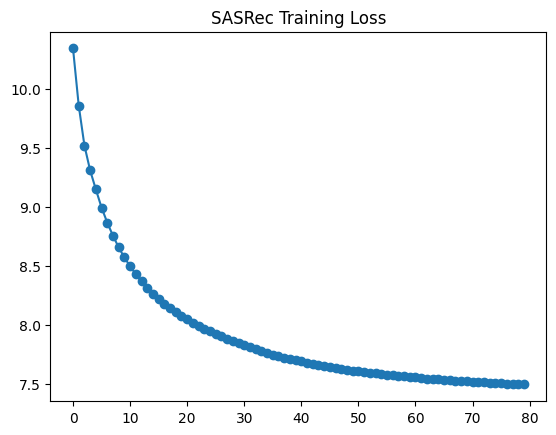

SASRec Prediction: 100%|██████████| 23926/23926 [01:45<00:00, 227.52it/s]


[SASRec] HR@50: 0.1525  NDCG@50: 0.0503
SASRec HR@50: 0.1525, NDCG@50: 0.0503


In [19]:
# --- Hyperparameters ---
max_len = 200
hidden_size = 64
epochs = 80
batch_size = 128
K = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 2. Model
model_sasrec = SASRecModel(
    num_items=num_items,
    max_len=max_len,
    hidden_size=hidden_size
).to(device)

train_dataset_sasrec = SASRecDataset(train, num_items=num_items, max_len=max_len)
train_loader_sasrec = DataLoader(train_dataset_sasrec, batch_size=batch_size, shuffle=True)

# 4. Train
loss_history = train_sasrec(model_sasrec, train_loader_sasrec, epochs, num_items, device)

# 5. Plot
import matplotlib.pyplot as plt
plt.plot(loss_history, marker='o')
plt.title('SASRec Training Loss')
plt.show()

# 6. Predict & Evaluate
sasrec_preds = predict_sasrec(
    model_sasrec,
    test,
    train,
    num_items=num_items,
    max_len=max_len,
    K=K,
    device=device
)

hr_SR, ndcg_SR = evaluate_model("SASRec", test, sasrec_preds, K=K)
print(f"SASRec HR@{K}: {hr_SR:.4f}, NDCG@{K}: {ndcg_SR:.4f}")

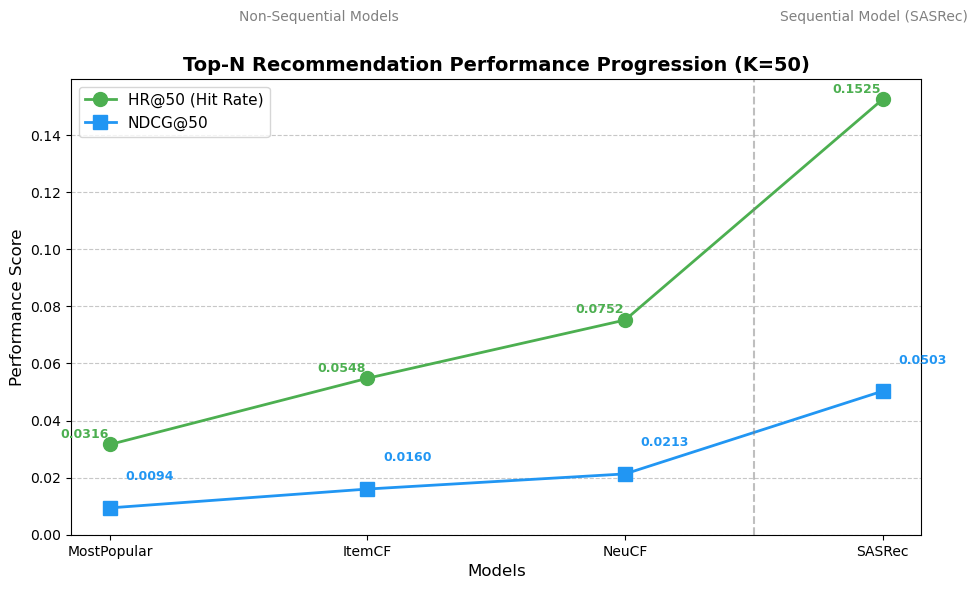

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data from your evaluation table
# We organize the models to reflect the increasing complexity and sequential nature
models = ['MostPopular', 'ItemCF', 'NeuCF', 'SASRec']
hr_50_scores = [0.0316, 0.0548, 0.0752, 0.1525]
ndcg_50_scores = [0.0094, 0.0160, 0.0213, 0.0503]

# --- Plotting Setup ---
# We use indices 0, 1, 2, 3 as the X-axis positions to represent the progression
x_positions = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot HR@50 as a line with markers
ax.plot(x_positions, hr_50_scores, 
        label='HR@50 (Hit Rate)', 
        marker='o', markersize=10, 
        linestyle='-', linewidth=2, 
        color='#4CAF50')

# Plot NDCG@50 as a line with markers
ax.plot(x_positions, ndcg_50_scores, 
        label='NDCG@50', 
        marker='s', markersize=10, 
        linestyle='-', linewidth=2, 
        color='#2196F3')

# --- Customization ---

# Add data labels (Annotations)
for i, (hr, ndcg) in enumerate(zip(hr_50_scores, ndcg_50_scores)):
    # HR@50 labels (slightly offset)
    ax.annotate(f'{hr:.4f}', 
                (x_positions[i] - 0.1, hr), 
                textcoords="offset points", xytext=(0, 5), 
                ha='center', fontsize=9, color='#4CAF50', fontweight='bold')
    
    # NDCG@50 labels (slightly offset)
    ax.annotate(f'{ndcg:.4f}', 
                (x_positions[i] + 0.1, ndcg), 
                textcoords="offset points", xytext=(10, 20), 
                ha='center', fontsize=9, color='#2196F3', fontweight='bold')

# Set labels and title
ax.set_ylabel('Performance Score', fontsize=12)
ax.set_xlabel('Models', fontsize=12) # Changed label to reflect the progression
ax.set_title('Top-N Recommendation Performance Progression (K=50)', fontsize=14, fontweight='bold')

# Set custom x-axis tick labels
ax.set_xticks(x_positions)
ax.set_xticklabels(models, rotation=0)

# Ensure y-axis starts at 0 for fair comparison
ax.set_ylim(bottom=0)

ax.legend(loc='upper left', fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add a vertical line/highlight to visually emphasize the transition to sequential modeling
ax.axvline(x=2.5, color='gray', linestyle='--', alpha=0.5, label='Sequential Boundary')
ax.text(2.6, 0.18, 'Sequential Model (SASRec)', color='gray', fontsize=10)
ax.text(0.5, 0.18, 'Non-Sequential Models', color='gray', fontsize=10)


fig.tight_layout()
plt.show()